<a href="https://colab.research.google.com/github/cheonghf/ML-P4-03/blob/main/Project_SourceCode_P4_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dataset_1 = 'https://raw.githubusercontent.com/cheonghf/ML-P4-03/refs/heads/main/bank_transactions_data_2.csv'

df_bt1 = pd.read_csv(dataset_1, index_col = 0) #retrive address with pandas to form banktransactions_dataframe1

Display the first 5 rows of the dataset

In [ ]:
bt_df1.head()

Display the last 5 rows of the dataset

In [ ]:
bt_df1.tail()

Understanding the Number of (Rows, Columns)

In [ ]:
bt_df1.shape

Understanding the Data Type in the DataFrame

In [ ]:
bt_df1.dtypes

Previewing of Column Labels in DataFrame

In [ ]:
bt_df1.columns

Understand if there is any null or missing data in the dataframe.


In [ ]:
bt_df1.isnull().sum(axis=0)

Understand the numerical value in DataFrame via statistic

In [ ]:
bt_df1.describe()

Understand the amount of Unique in Column 'Channel' of DataFrame

In [ ]:
bt_df1.Channel.value_counts()

#RUN: Understand TransactionAmount for Different Types of Channel

In [109]:
list_channel = ['ATM', 'Online', 'Branch']

for x in list_channel:
  df_channel = df_bt1[df_bt1['Channel'] == x]
  print(x, df_channel['TransactionAmount'].describe())
  print()

ATM count     833.000000
mean      307.720804
std       303.512346
min         0.320000
25%        84.890000
50%       218.960000
75%       427.690000
max      1919.110000
Name: TransactionAmount, dtype: float64

Online count     811.000000
mean      297.214723
std       293.203307
min         0.260000
25%        79.340000
50%       206.630000
75%       414.630000
max      1831.020000
Name: TransactionAmount, dtype: float64

Branch count     868.000000
mean      288.229263
std       279.188898
min         0.450000
25%        83.197500
50%       204.160000
75%       401.935000
max      1664.330000
Name: TransactionAmount, dtype: float64



Display the Above into a Box Plot for ease of visualisation

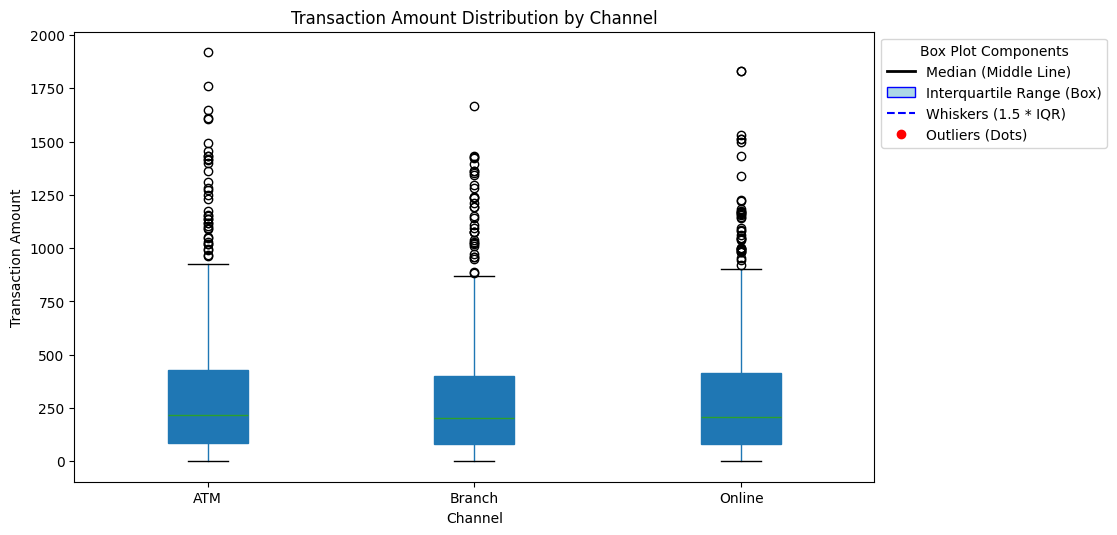

In [110]:
# Create a box plot with a better legend placement
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df_bt1.boxplot(column='TransactionAmount', by='Channel', grid=False, ax=ax, patch_artist=True)

# Set titles and labels
ax.set_title("Transaction Amount Distribution by Channel")
plt.suptitle("")  # Remove default matplotlib title
ax.set_xlabel("Channel")
ax.set_ylabel("Transaction Amount")

# Define legend elements
median_line = plt.Line2D([], [], color='black', linewidth=2, label="Median (Middle Line)")
box_patch = plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', edgecolor='blue', label="Interquartile Range (Box)")
whiskers_line = plt.Line2D([], [], color='blue', linestyle='--', linewidth=1.5, label="Whiskers (1.5 * IQR)")
outliers_dots = plt.Line2D([], [], color='red', marker='o', linestyle='None', label="Outliers (Dots)")

# Move legend to upper left outside the plot area
ax.legend(handles=[median_line, box_patch, whiskers_line, outliers_dots], title="Box Plot Components", loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


#RUN: We plan to focus on 'Channel' and Calculate the percentage of each Channel Transactions against the Account Balance to detect fraud











In [111]:
dict_channel = {"ATM":0, "Branch":1, "Online":2 }

df_bt_cleaned = df_bt1.loc[:, ['AccountID', 'CustomerAge', 'LoginAttempts', 'TransactionAmount', 'AccountBalance', 'Channel']]

for x, y in df_bt_cleaned.iterrows():
  df_bt_cleaned['ChannelRef']  = df_bt_cleaned["Channel"].map(dict_channel)

df_trans_percentage =  (df_bt_cleaned['TransactionAmount'] / (df_bt_cleaned['TransactionAmount'] + df_bt_cleaned['AccountBalance'])) * 100 #Calculation of OnlineTransactionPercentage

df_trans_diff = pd.DataFrame(df_bt_cleaned["TransactionAmount"] >= df_bt_cleaned["AccountBalance"]) #Return True to DataFrame Online Difference if TransactionAmount greater or equal to AccountBalance

#df_deviceID = df_bt_cleaned['DeviceID'].str[2:].astype(int)

df_bt_cleaned['TransactionPercentage'] = df_trans_percentage #Insert Calculated OnlineTransactionPercentage

df_bt_cleaned['TransactionDifference'] = df_trans_diff #Insert OnlineTransactionDifference

#df_bt_cleaned['DeviceID'] = df_deviceID

df_bt_cleaned = df_bt_cleaned.set_index('AccountID', drop = False) #Set Index Label to 'AccountID'

print(df_bt_cleaned)


          AccountID  CustomerAge  LoginAttempts  TransactionAmount  \
AccountID                                                            
AC00128     AC00128           70              1              14.09   
AC00455     AC00455           68              1             376.24   
AC00019     AC00019           19              1             126.29   
AC00070     AC00070           26              1             184.50   
AC00411     AC00411           26              1              13.45   
...             ...          ...            ...                ...   
AC00297     AC00297           33              1             856.21   
AC00322     AC00322           48              1             251.54   
AC00095     AC00095           56              1              28.63   
AC00118     AC00118           23              1             185.97   
AC00009     AC00009           24              1             243.08   

           AccountBalance Channel  ChannelRef  TransactionPercentage  \
AccountID        

Understand how many Online Transacation Amount is NOT Larger or Equal to AccountBalance in the DataFrame of Online Difference

In [112]:
df_trans_diff.describe()

,0
count,2512
unique,2
top,False
freq,2393


Understand CustomerAge statistic for OnlineTransactions

In [113]:
df_bt_cleaned['CustomerAge'].describe()

,CustomerAge
count,2512.000000
mean,44.673965
std,17.792198
min,18.000000
25%,27.000000
50%,45.000000
75%,59.000000
max,80.000000


Understand each category (min to max) of total number of LoginAttempts in the DataFrame of Online Cleaned

In [114]:
for x in range (1,6):
  count_x = df_bt_cleaned['LoginAttempts'].value_counts().get(x)
  print("Occurrences of LoginAttempts", x ,":", count_x)

Occurrences of LoginAttempts 1 : 2390
Occurrences of LoginAttempts 2 : 27
Occurrences of LoginAttempts 3 : 31
Occurrences of LoginAttempts 4 : 32
Occurrences of LoginAttempts 5 : 32


Understand the number of unique AccountID in DataFrame of Online Cleaned

In [115]:
df_bt_cleaned.AccountID.unique().size

495

Show correlation Heat Map and Matrix

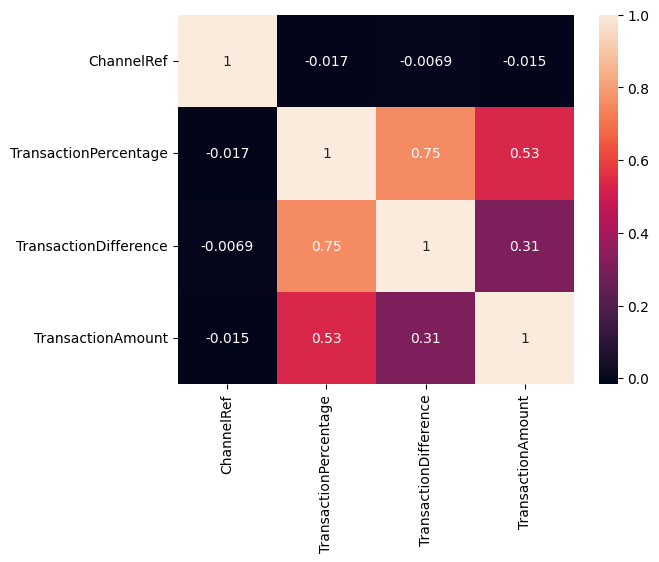

In [116]:
df_bt_cleaned_corr = df_bt_cleaned.get(['ChannelRef', 'TransactionPercentage','TransactionDifference', 'TransactionAmount'])

corrmat = df_bt_cleaned_corr.corr()

sns.heatmap(corrmat,annot = True)
plt.show()

#RUN: Feed the required data into the Logistic Regression Model for Binary Classification

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df_bt_cleaned.loc[:, ['TransactionPercentage', 'TransactionAmount']]
y = df_bt_cleaned['TransactionDifference']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=1)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#RUN: Prediction, Accuracy Score, Confusion Matrix & Classification Report

Accuracy of the binary classifier = 0.999



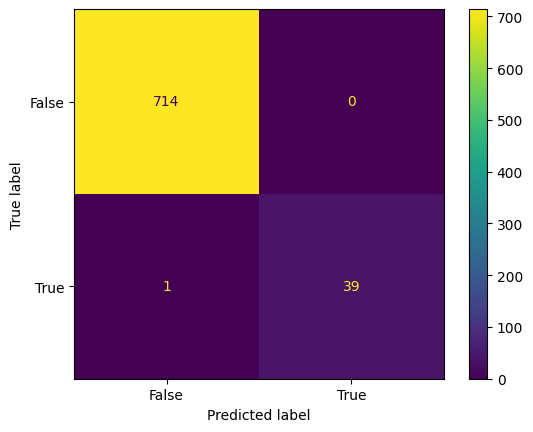


Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       714
        True       1.00      0.97      0.99        40

    accuracy                           1.00       754
   macro avg       1.00      0.99      0.99       754
weighted avg       1.00      1.00      1.00       754



In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

# Predict on Test Data
y_pred = model.predict(X_test)

# Evaluate accuracy of the model, (TP + TN) / (TP + FP + TN + FN)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

print()

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print()

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

ROC Curve & AUC Score (May be wrong, need look into this if we want to keep this)

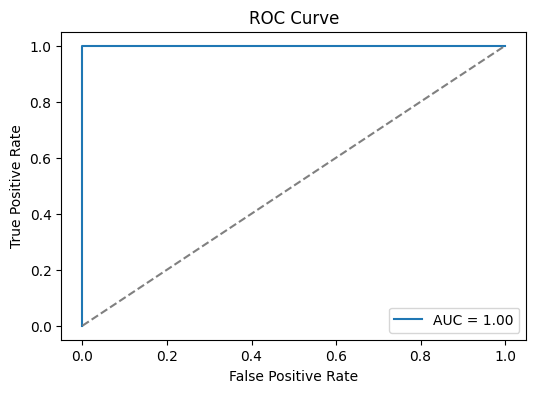

In [120]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get probability scores
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#RUN: Hyperparameter Tuning the Model for Better Performance

Logistic Regression has parameters like C (regularization). We can tune them using Grid Search.

In [121]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Run GridSearchCV
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'C': 0.01}


#RUN: Retrain the model

In [122]:
# Get the best parameter
best_C = grid_search.best_params_['C']

# Train the final model with the best parameters
final_model = LogisticRegression(C=best_C, random_state=1)
final_model.fit(X_train, y_train)


LogisticRegression(C=0.01, random_state=1)

#RUN: Final Prediction, Final Accuracy Score, Final Confusion Matrix & Final Classification Report

Final Model Accuracy: 0.997



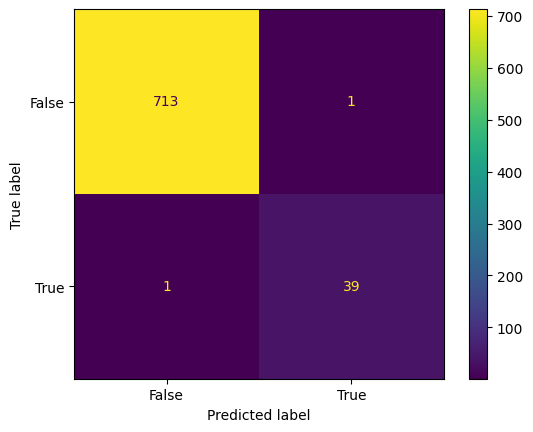


Final Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       714
        True       0.97      0.97      0.97        40

    accuracy                           1.00       754
   macro avg       0.99      0.99      0.99       754
weighted avg       1.00      1.00      1.00       754



In [123]:
# Predict on test data
y_final_pred = final_model.predict(X_test)

# Print accuracy
final_accuracy = accuracy_score(y_test, y_final_pred)
print(f'Final Model Accuracy: {final_accuracy:.3f}')

print()

# Print confusion matrix
cm = confusion_matrix(y_test, y_final_pred)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, y_final_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print()

# Print classification report
print("Final Classification Report:\n", classification_report(y_test, y_final_pred))

#RUN: Save the Trained Logistic Regression Binary Class Model

In [124]:
import joblib

# Save the model
joblib.dump(final_model, 'log_reg_binaryclass_model_best.pkl')

['log_reg_binaryclass_model_best.pkl']

#RUN: Feed New Data into Final Model for Experimentation

In [126]:
# Load model
lgr_bc_model = joblib.load('log_reg_binaryclass_model_best.pkl')

# Define feature names based on the training data
feature_names = ['TransactionPercentage', 'TransactionAmount']

# Feed New Test Data
X_new = np.array([[70,10], [80,5000], [10,1000], [55,100], [30,88]]) # Change your Numbers HERE

# Convert X_new to a pandas DataFrame with feature names
X_new_df = pd.DataFrame(X_new, columns=feature_names)

# Predict using the loaded model
new_predictions = lgr_bc_model.predict(X_new_df)

# Print new_predictions result
print("Predicted Outcome:", new_predictions)  # Output will be either 0 or 1

Predicted Outcome: [ True  True False  True False]


#**MISC**

In [ ]:
'''
Old Test Run
'''

bt_df1_corr = bt_df1.get(['TransactionAmount', 'CustomerAge', 'AccountBalance'])

corrmat = bt_df1_corr.corr()

sns.heatmap(corrmat,annot = True)
plt.show()